## Toy Model to generate time series data
Given an underlying network structure (directed weighted graph), we generate time series data for each node in the network. The time series data is generated by a linear combination of the time series data of its neighbors. The coefficients of the linear combination are randomly generated from a uniform distribution. The time series data of the nodes are generated by a random walk process. The random walk process is a first order Markov process. The transition matrix is randomly generated from a uniform distribution. The initial state of the random walk process is randomly generated from a uniform distribution.

In [141]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scienceplots



def generate_directed_graph(num_nodes):
    """
    Generates a random directed weighted graph.
    :param num_nodes: Number of nodes in the graph.
    :return: A NetworkX DiGraph object.
    """
    G = nx.DiGraph()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and np.random.rand() < 0.5:  # Adjust probability as needed
                weight = np.random.rand()
                G.add_edge(i, j, weight=weight)
    return G

def generate_graph(num_nodes, network_type, random_weights=True):
    """
    Generates a graph based on the specified number of nodes and network type.
    
    :param num_nodes: Number of nodes in the graph.
    :param network_type: Type of network ('chain', 'dag', 'sparse', or 'clustered').
    :param random_weights: If True, assigns random weights to edges; otherwise, no weights are assigned.
    :return: A NetworkX graph.
    """
    if network_type == 'chain':
        graph = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    elif network_type == 'dag':
        graph = nx.gn_graph(num_nodes, create_using=nx.DiGraph())
    elif network_type == 'sparse':
        graph = nx.erdos_renyi_graph(num_nodes, 0.2, directed=True)
    elif network_type == 'clustered':
        graph = nx.barabasi_albert_graph(num_nodes, 2, seed=42, directed=True)
    else:
        raise ValueError("Invalid network type. Supported types are 'chain', 'dag', 'sparse', and 'clustered'.")

    if random_weights:
        for edge in graph.edges(data=True):
            edge[2]['weight'] = np.random.rand()

    return graph


def initialize_states(graph, state_size):
    """
    Initializes the states for each node.
    :param graph: A NetworkX DiGraph object.
    :param state_size: The size of the state vector for each node.
    :return: A dictionary of initial states for each node.
    """
    states = {node: np.random.randn(state_size) for node in graph.nodes()}
    return states

def create_dataframe(graph, state_size, time_steps):
    """
    Creates an empty DataFrame to store the time series data.
    :param graph: A NetworkX DiGraph object.
    :param state_size: The size of the state vector for each node.
    :param time_steps: Number of time steps for the simulation.
    :return: An empty DataFrame with appropriate columns.
    """
    columns = [f'node_{node}' for node in graph.nodes()]  # One column per node
    df = pd.DataFrame(index=range(time_steps), columns=columns)
    return df


def define_var_coefficients(graph, state_size):
    coefficients = {}
    for node in graph.nodes():
        incoming_edges = graph.in_edges(node, data=True)
        if incoming_edges:
            # Initialize coefficients matrix
            coeffs_matrix = np.zeros((state_size, len(incoming_edges) * state_size))
            for i, (_, pred, data) in enumerate(incoming_edges):
                weight = data['weight']
                for j in range(state_size):
                    coeffs_matrix[j, i * state_size + j] = weight
            coefficients[node] = coeffs_matrix
        else:
            coefficients[node] = np.zeros((state_size, state_size))
    return coefficients

def generate_coefficients(graph, state_size, lag):
    coefficients = {}
    for node in graph.nodes():
        # Coefficients for the node's own past states (A_i,j)
        self_coeffs = np.random.randn(lag, state_size, state_size)

        # Coefficients for the states of neighboring nodes (B_i,k,j)
        incoming_edges = graph.in_edges(node, data=True)
        neighbor_coeffs = {pred: np.random.randn(lag, state_size, state_size) * data['weight']
                           for pred, _, data in incoming_edges}

        # Constant term (A_i,0)
        constant_term = np.random.randn(state_size)

        coefficients[node] = (self_coeffs, neighbor_coeffs, constant_term)

    return coefficients


def advance_var_model(coefficients, states, df, time_step, state_size, lag):
    new_states = {}
    for node, (self_coeffs, neighbor_coeffs, constant_term) in coefficients.items():
        next_state = np.copy(constant_term)  # Start with the constant term

        # Add the node's own past states
        for l in range(1, lag + 1):
            if time_step - l >= 0:
                past_state_values = df.at[time_step - l, f'node_{node}']
                next_state += np.dot(self_coeffs[l - 1], past_state_values)

        # Add the past states of neighboring nodes
        for pred, coeffs in neighbor_coeffs.items():
            for l in range(1, lag + 1):
                if time_step - l >= 0:
                    pred_past_state_values = df.at[time_step - l, f'node_{pred}']
                    next_state += np.dot(coeffs[l - 1], pred_past_state_values)

        # Optional: Include error term (e_i(t))
        error_term = np.random.normal(0, 1, state_size)
        next_state += error_term

        new_states[node] = next_state

    return new_states



def visualize_graph(graph):
    """
    Visualizes a directed weighted graph.
    :param graph: A NetworkX DiGraph object.
    """
    plt.figure(figsize=(12, 8))
    
    # Node positions
    pos = nx.spring_layout(graph, seed=42)  # You can change the layout as needed

    # Draw nodes
    node_sizes = [graph.degree(node) * 100 for node in graph.nodes()]  # Adjust node size
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes)

    # Draw edges
    edge_widths = 100*[graph[u][v]['weight'] for u, v in graph.edges()]
    nx.draw_networkx_edges(graph, pos, arrowstyle='->', arrowsize=40, width=edge_widths,edge_color='yellow')

    # Draw node labels
    nx.draw_networkx_labels(graph, pos)

    plt.title("Directed Weighted Graph")
    plt.axis('off')
    plt.show()
    
def visualize_graph_enhanced(graph):
    """
    Visualizes a directed weighted graph in an enhanced, more aesthetic manner.
    :param graph: A NetworkX DiGraph object.
    """
    plt.figure(figsize=(15, 10))
    
    # Node positions using a layout that spreads out the nodes for better visualization
    #pos = nx.kamada_kawai_layout(graph)
    pos = nx.shell_layout(graph)




    # Node colors and sizes based on degree
    degrees = np.array([graph.degree(node) for node in graph.nodes()])
    node_colors = (degrees+10) / (degrees.max()+10)
    node_sizes = 550  # Scaling node sizes

    # Draw nodes with colormap
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=node_sizes, alpha=0.9)

    # Draw edges with varying width and edge color
    edge_widths = [5 * graph[u][v]['weight'] for u, v in graph.edges()]
    nx.draw_networkx_edges(graph, pos, edge_color='grey', arrowstyle='->', arrowsize=20, width=edge_widths)

    # Draw node labels with a specific font size
    nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')

    plt.title("Underlying Causal Graph", size=20, color='grey')

    plt.axis('off')
    plt.show()

def plot_time_series(df, nodes, time_steps):
    """
    Plots the time series data for a subset of nodes in an enhanced, more aesthetic manner.
    :param df: DataFrame containing the time series data.
    :param nodes: List of nodes to plot.
    :param time_steps: Total number of time steps.
    """
    plt.figure(figsize=(12, 6))  # Adjusted for better aspect ratio

    # Use a colormap
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(nodes)))

    for idx, node in enumerate(nodes):
        states = df[f'node_{node}'].apply(lambda x: x[0] if x is not None else None)
        plt.plot(range(time_steps), states, label=f'Node {node}', color=colors[idx], linewidth=2)
        
    plt.style.use(['science','ieee'])
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.title('Time Series Data for Nodes', fontsize=14)
    plt.grid(True)  # Adding gridlines for readability
    plt.legend(fontsize=10)
    plt.show()




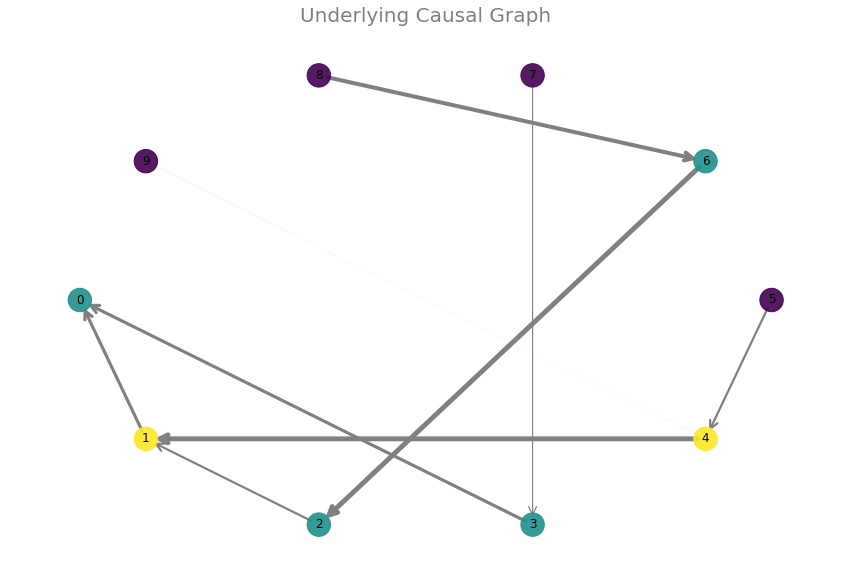

In [131]:
#create graph and plot it
#make empty graph
graph = generate_graph(10, 'dag', random_weights=True)
visualize_graph_enhanced(graph)

In [140]:
import networkx as nx
import numpy as np
import pandas as pd
import random


def run_var_simulation(num_nodes, state_size, lag, init_time, total_time_steps):
    # Generate graph
    graph = generate_directed_graph(num_nodes)

    # Initialize states and coefficients
    coefficients = generate_coefficients(graph, state_size, lag)

    # Create DataFrame to store time series
    df = create_dataframe(graph, state_size, total_time_steps)

    # Populate initial state in DataFrame
    states = {}
    for t in range(init_time):
        new_states = initialize_states(graph, state_size)
        states.update(new_states)
        for node, state in new_states.items():
            df.at[t, f'node_{node}'] = state

    # Simulation loop
    for t in range(init_time, total_time_steps):
        new_states = advance_var_model(coefficients, states, df, t, state_size, lag)
        states.update(new_states)

        # Store new state in DataFrame
        for node, state in new_states.items():
            df.at[t, f'node_{node}'] = state

    return df

def random_node_sample(num_nodes, percentage):
    """
    Returns a random sample of nodes from a graph as a percentage of the original nodes.
    
    :param graph: A NetworkX graph.
    :param percentage: Percentage of nodes to sample (0.0 to 1.0).
    :return: List of randomly sampled nodes.
    """
    sample_size = int(percentage * num_nodes)
    sampled_nodes = random.sample(graph.nodes(), sample_size)
    return sampled_nodes



/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_78200/775959854.py:45: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(graph.nodes(), sample_size)


[7, 8]


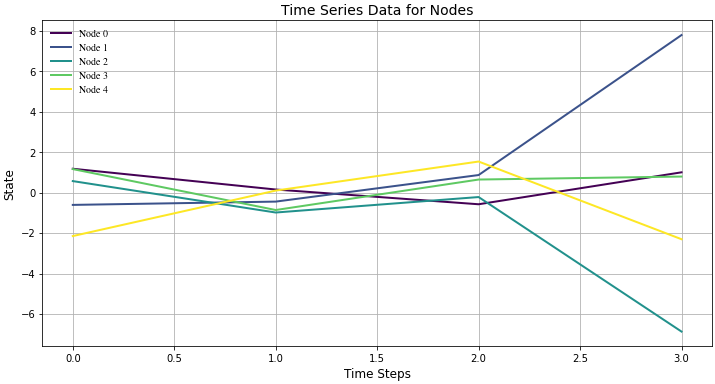

In [142]:

# Simulation Parameters
num_nodes = 5
state_size = 2
lag = 1
init_time = lag + 1
time_steps = 2 + init_time

# Run the simulation
resulting_dataframe = run_var_simulation(num_nodes, state_size, lag, init_time, time_steps)


#sample nodes
sampled_nodes = random_node_sample(num_nodes, 0.5)
print(sampled_nodes)



plot_time_series(resulting_dataframe, [0, 1, 2, 3, 4], time_steps)

In [84]:
import numpy as np
import pandas as pd
import networkx as nx


def generate_directed_graph(num_nodes):
    """
    Generates a random directed weighted graph.
    :param num_nodes: Number of nodes in the graph.
    :return: A NetworkX DiGraph object.
    """
    G = nx.DiGraph()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and np.random.rand() < 0.5:  # Adjust probability as needed
                weight = np.random.rand()
                G.add_edge(i, j, weight=weight)
    return G


def initialize_states(graph, state_size):
    """
    Initializes the states for each node.
    :param graph: A NetworkX DiGraph object.
    :param state_size: The size of the state vector for each node.
    :return: A dictionary of initial states for each node.
    """
    states = {node: np.random.randn(state_size) for node in graph.nodes()}
    return states

def create_dataframe(graph, state_size, time_steps):
    """
    Creates an empty DataFrame to store the time series data.
    :param graph: A NetworkX DiGraph object.
    :param state_size: The size of the state vector for each node.
    :param time_steps: Number of time steps for the simulation.
    :return: An empty DataFrame with appropriate columns.
    """
    columns = [f'node_{node}' for node in graph.nodes()]  # One column per node
    df = pd.DataFrame(index=range(time_steps), columns=columns)
    return df


def define_var_coefficients(graph, state_size):
    coefficients = {}
    for node in graph.nodes():
        incoming_edges = graph.in_edges(node, data=True)
        if incoming_edges:
            # Initialize coefficients matrix
            coeffs_matrix = np.zeros((state_size, len(incoming_edges) * state_size))
            for i, (_, pred, data) in enumerate(incoming_edges):
                weight = data['weight']
                for j in range(state_size):
                    coeffs_matrix[j, i * state_size + j] = weight
            coefficients[node] = coeffs_matrix
        else:
            coefficients[node] = np.zeros((state_size, state_size))
    return coefficients

def generate_coefficients(graph, state_size, lag):
    coefficients = {}
    for node in graph.nodes():
        # Coefficients for the node's own past states (A_i,j)
        self_coeffs = np.random.randn(lag, state_size, state_size)

        # Coefficients for the states of neighboring nodes (B_i,k,j)
        incoming_edges = graph.in_edges(node, data=True)
        neighbor_coeffs = {pred: np.random.randn(lag, state_size, state_size) * data['weight']
                           for pred, _, data in incoming_edges}

        # Constant term (A_i,0)
        constant_term = np.random.randn(state_size)

        coefficients[node] = (self_coeffs, neighbor_coeffs, constant_term)

    return coefficients


def advance_var_model(coefficients, states, df, time_step, state_size, lag):
    new_states = {}
    for node, (self_coeffs, neighbor_coeffs, constant_term) in coefficients.items():
        next_state = np.copy(constant_term)  # Start with the constant term

        # Add the node's own past states
        for l in range(1, lag + 1):
            if time_step - l >= 0:
                past_state_values = df.at[time_step - l, f'node_{node}']
                next_state += np.dot(self_coeffs[l - 1], past_state_values)

        # Add the past states of neighboring nodes
        for pred, coeffs in neighbor_coeffs.items():
            for l in range(1, lag + 1):
                if time_step - l >= 0:
                    pred_past_state_values = df.at[time_step - l, f'node_{pred}']
                    next_state += np.dot(coeffs[l - 1], pred_past_state_values)

        # Optional: Include error term (e_i(t))
        error_term = np.random.normal(0, 1, state_size)
        next_state += error_term

        new_states[node] = next_state

    return new_states




# Simulation Parameters
num_nodes = 5
state_size = 2
lag = 1  # Define the lag value
init_time = lag + 1  # Number of time steps to initialize the states
time_steps = 2 + init_time  # Total number of time steps for the simulation

# Generate graph
graph = generate_directed_graph(num_nodes)

# Initialize states and coefficients
coefficients = generate_coefficients(graph, state_size, lag)


# Create DataFrame to store time series
df = create_dataframe(graph, state_size, time_steps)


# Populate initial state in DataFrame
for t in range(init_time):
    states = initialize_states(graph, state_size)
    for node, state in states.items():
        df.at[t, f'node_{node}'] = state

# Simulation loop
for t in range(init_time, time_steps):
    states = advance_var_model(coefficients, states, df, t, state_size, lag)

    # Store new state in DataFrame
    for node, state in states.items():
        df.at[t, f'node_{node}'] = state




                                       node_0  \
0  [-0.2832438044080302, -0.4020984011638009]   
1  [0.6710460572329036, -0.30048930425433923]   
2   [-0.4388556447927128, -2.488572673232646]   
3   [-1.4396782440380202, 0.9541529781738387]   

                                       node_1  \
0    [0.9137005912247014, 0.4764740541024688]   
1   [-1.0541910335657878, 1.3730882610321085]   
2    [0.8843063017399238, 1.0194289545628816]   
3  [-3.3763237750882498, -0.7768311306424583]   

                                       node_2  \
0  [0.5450775427359608, -0.03785049197429281]   
1  [1.5539903788760385, -0.05665894798953107]   
2      [-3.632579413777593, 4.61008552074164]   
3     [16.08675428594512, -8.617850136806705]   

                                        node_3  \
0   [0.7703030984415228, -0.45779623966062705]   
1   [-1.3303982244770285, -1.9555736904718226]   
2  [-0.48757596217620836, -0.9181680810019845]   
3    [-1.5617804656411407, 1.1008940295304959]   

           

In [53]:

import numpy as np
import pandas as pd

# Create a sample next_state dictionary with numpy arrays
next_state = {
    0: np.array([-0.59116]),
    1: np.array([-1.16700853]),
    2: np.array([-2.59411598]),
    3: np.array([2.27283527]),
    4: np.array([0.0631233])
}

# Create a DataFrame to store values
df = pd.DataFrame()
#initialize the columns
for i in range(len(next_state)):
    df[f'node_{i}'] = np.nan



# Simulate the code snippet
time_step = 0  # You can change this value as needed
node = 'A'     # You can change this value as needed

#save the array in the dataframe in for loop
for i in range(len(next_state)):
    df.at[time_step, f'node_{i}'] = next_state[i]

print(df.head())

[-0.59116] next state
[-1.16700853] next state
[-2.59411598] next state
[2.27283527] next state
[0.0631233] next state
    node_0    node_1    node_2    node_3    node_4
0 -0.59116 -1.167009 -2.594116  2.272835  0.063123
